In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
class LSGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(LSGAN, self).__init__()
        self.x_dim  = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(LSGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        activation = 'relu'
        inputs = Input(shape=(self.z_dim, ))
        h = Dense(256)(inputs)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(512)(h)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(1024)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.x_dim[0], activation='tanh')(h)
        
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        activation = leakyrelu
        inputs = Input(shape = self.x_dim)
        h = Dense(512)(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(1)(h)

        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [4]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [5]:
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = train_X.reshape(-1, 28*28)

In [6]:
gan = LSGAN(train_X.shape[1:], 100)
gan.generator.summary()
print('#'*50)
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               20

Epoch 1/101
1867/1875 [============================>.] - ETA: 0s - d_loss: 0.2148 - g_loss: 0.8637

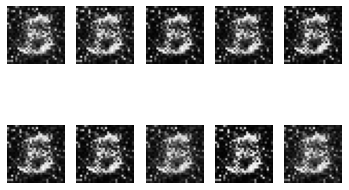

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.2140 - g_loss: 0.8648
Epoch 2/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.0688 - g_loss: 0.9697
Epoch 3/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.0510 - g_loss: 0.9544
Epoch 4/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.0810 - g_loss: 0.8949
Epoch 5/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1068 - g_loss: 0.8104
Epoch 6/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1264 - g_loss: 0.7333
Epoch 7/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1434 - g_loss: 0.6643
Epoch 8/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1502 - g_loss: 0.6433
Epoch 9/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1576 - g_loss: 0.6178
Epoch 10/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.166

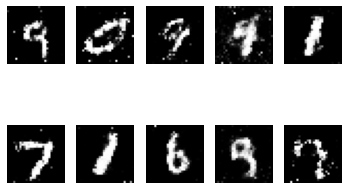

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1680 - g_loss: 0.5859
Epoch 12/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1725 - g_loss: 0.5672
Epoch 13/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1740 - g_loss: 0.5617
Epoch 14/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1772 - g_loss: 0.5507
Epoch 15/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1764 - g_loss: 0.5460
Epoch 16/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1796 - g_loss: 0.5395
Epoch 17/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1803 - g_loss: 0.5373
Epoch 18/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1798 - g_loss: 0.5344
Epoch 19/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1814 - g_loss: 0.5289
Epoch 20/101
1875/1875 [==============================] - 8s 4ms/step - d_los

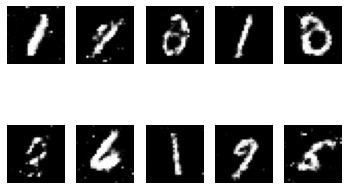

1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1807 - g_loss: 0.5287
Epoch 22/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1823 - g_loss: 0.5239
Epoch 23/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1817 - g_loss: 0.5251
Epoch 24/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1832 - g_loss: 0.5194
Epoch 25/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1838 - g_loss: 0.5163
Epoch 26/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1857 - g_loss: 0.5105
Epoch 27/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1854 - g_loss: 0.5116
Epoch 28/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1850 - g_loss: 0.5104
Epoch 29/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1854 - g_loss: 0.5079
Epoch 30/101
1875/1875 [==============================] - 8s 5ms/step - d_los

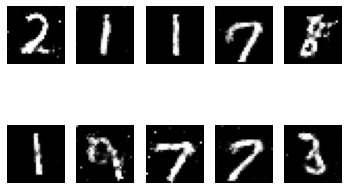

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1868 - g_loss: 0.5031
Epoch 32/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1862 - g_loss: 0.5052
Epoch 33/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1855 - g_loss: 0.5043
Epoch 34/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1875 - g_loss: 0.5008
Epoch 35/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1890 - g_loss: 0.4948
Epoch 36/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1889 - g_loss: 0.4960
Epoch 37/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1888 - g_loss: 0.4970
Epoch 38/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1905 - g_loss: 0.4898
Epoch 39/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1904 - g_loss: 0.4909
Epoch 40/101
1875/1875 [==============================] - 8s 5ms/step - d_los

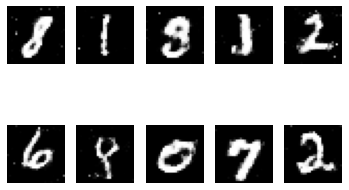

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1904 - g_loss: 0.4911
Epoch 42/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1902 - g_loss: 0.4903
Epoch 43/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1903 - g_loss: 0.4918
Epoch 44/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1904 - g_loss: 0.4890
Epoch 45/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1899 - g_loss: 0.4911
Epoch 46/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1911 - g_loss: 0.4872
Epoch 47/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1908 - g_loss: 0.4857
Epoch 48/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1913 - g_loss: 0.4865
Epoch 49/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1921 - g_loss: 0.4819
Epoch 50/101
1875/1875 [==============================] - 9s 5ms/step - d_los

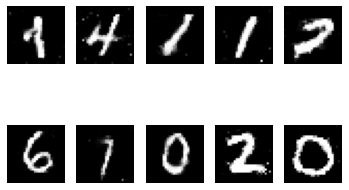

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1904 - g_loss: 0.4867
Epoch 52/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1892 - g_loss: 0.4890
Epoch 53/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1906 - g_loss: 0.4861
Epoch 54/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1893 - g_loss: 0.4886
Epoch 55/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1891 - g_loss: 0.4885
Epoch 56/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1891 - g_loss: 0.4902
Epoch 57/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1888 - g_loss: 0.4911
Epoch 58/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1890 - g_loss: 0.4897
Epoch 59/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1886 - g_loss: 0.4892
Epoch 60/101
1875/1875 [==============================] - 10s 5ms/step - d_lo

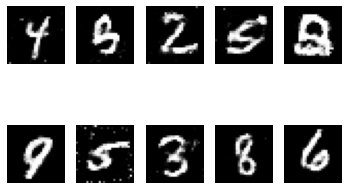

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1870 - g_loss: 0.4949
Epoch 62/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1883 - g_loss: 0.4926
Epoch 63/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1874 - g_loss: 0.4927
Epoch 64/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1867 - g_loss: 0.4940
Epoch 65/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1868 - g_loss: 0.4938
Epoch 66/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1874 - g_loss: 0.4927
Epoch 67/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1868 - g_loss: 0.4959
Epoch 68/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1861 - g_loss: 0.4968
Epoch 69/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1859 - g_loss: 0.4950
Epoch 70/101
1875/1875 [==============================] - 9s 5ms/step - d_los

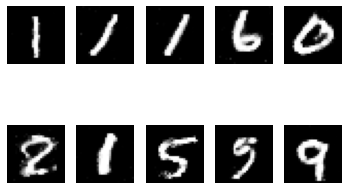

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1864 - g_loss: 0.4967
Epoch 72/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1870 - g_loss: 0.4929
Epoch 73/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1858 - g_loss: 0.4976
Epoch 74/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1861 - g_loss: 0.4975
Epoch 75/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1852 - g_loss: 0.4997
Epoch 76/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1852 - g_loss: 0.4999
Epoch 77/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1849 - g_loss: 0.4989
Epoch 78/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1853 - g_loss: 0.4990
Epoch 79/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1850 - g_loss: 0.5002
Epoch 80/101
1875/1875 [==============================] - 9s 5ms/step - d_los

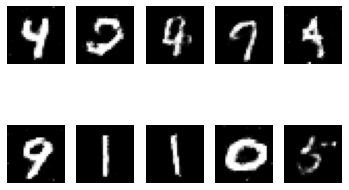

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1841 - g_loss: 0.5016
Epoch 82/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1838 - g_loss: 0.5030
Epoch 83/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1833 - g_loss: 0.5035
Epoch 84/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1844 - g_loss: 0.5017
Epoch 85/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1840 - g_loss: 0.4994
Epoch 86/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1843 - g_loss: 0.5012
Epoch 87/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1842 - g_loss: 0.5014
Epoch 88/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1825 - g_loss: 0.5041
Epoch 89/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1838 - g_loss: 0.5032
Epoch 90/101
1875/1875 [==============================] - 9s 5ms/step - d_los

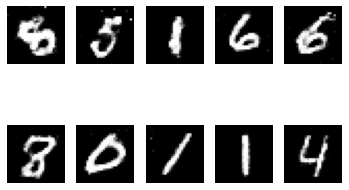

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1821 - g_loss: 0.5084
Epoch 92/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1818 - g_loss: 0.5076
Epoch 93/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1817 - g_loss: 0.5074
Epoch 94/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1820 - g_loss: 0.5056
Epoch 95/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1820 - g_loss: 0.5067
Epoch 96/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1816 - g_loss: 0.5078
Epoch 97/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1812 - g_loss: 0.5076
Epoch 98/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1817 - g_loss: 0.5093
Epoch 99/101
1875/1875 [==============================] - 8s 5ms/step - d_loss: 0.1808 - g_loss: 0.5092
Epoch 100/101
1875/1875 [==============================] - 9s 5ms/step - d_lo

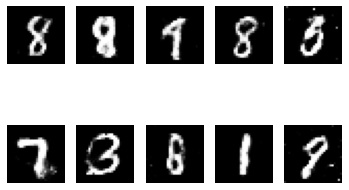

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.1804 - g_loss: 0.5105


In [7]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.MeanSquaredError(), 
         )

gan.fit(train_X,
       epochs=101,
       shuffle=True,
       batch_size=32,
       callbacks=[PlotCallback()])